## Binary classification with Logic Tensor Networks

This is a basic example in which we learn the grounding of a unary predicate $A$ that is defined in the space of $[0,1]^2$.
We define the predicate to apply to points that are close to the middle point $c=(.5,.5)$. In order to get training data, we randomly sample data from the domain. We split the sample data into two separate sets based on whether their euclidian distance to $c$ is smaller than $.09$. We then define two facts for the predicate $A$. For all points that the predicate should apply to, we provide them as positive examples and vice versa for all points that the predicate does not apply to.

In [1]:
import logging;logging.basicConfig(level=logging.INFO); # enabling logging.INFO prints some information in training
import numpy as np;
import matplotlib.pyplot as plt;

# adding parent directory to sys.path (ltnw is in parent dir)
import sys, os
sys.path.insert(0,os.path.normpath(os.path.join(os.path.abspath(''),os.path.pardir)))
import logictensornetworks_wrapper as ltnw;

Set the number of random training samples, the maximum number of epochs and how often we query the knowledgebase sat level in training.

In [2]:
nr_samples=500
max_epochs=10000
track_sat_levels=1000

Sample random data from $[0,1]^2$

In [3]:
data=np.random.uniform([0,0],[1.,1.],(nr_samples,2)).astype(np.float32)

Our groundtruth positive training data for $A$ is close to the center (.5,.5). All other data is considered as negative examples.

In [4]:
data_A=data[np.where(np.sum(np.square(data-[.5,.5]),axis=1)<.09)]
data_not_A=data[np.where(np.sum(np.square(data-[.5,.5]),axis=1)>=.09)]

We use three variables for feeding data to $A$.

In [5]:
ltnw.variable("?data_A",data_A); # all points
ltnw.variable("?data_not_A",data_not_A); # points for which A is true
ltnw.variable("?data",data); # points for which A is NOT true

Define the predicate $A$. $A$ has arity 1 (single argument) with 2 dimensions (since the domain is $[0,1]^2$)

In [6]:
ltnw.predicate("A",2);

Now we add some facts to the knowledgebase. We express that for all points in $\mathrm{?data\_A}$, $A$ should be true. For all points in $\mathrm{?data\_not\_A}$, $A$ is not true.

In [7]:
ltnw.axiom("forall ?data_A: A(?data_A)");
ltnw.axiom("forall ?data_not_A: ~A(?data_not_A)");

Initialize the knowledgebase and train the single predicate knowledgebase.

In [8]:
ltnw.initialize_knowledgebase(initial_sat_level_threshold=.1);
sat_level=ltnw.train(track_sat_levels=track_sat_levels,sat_level_epsilon=.99,max_epochs=max_epochs);

INFO:logictensornetworks_wrapper:Initializing knowledgebase
INFO:logictensornetworks_wrapper:Initializing Tensorflow session
INFO:logictensornetworks_wrapper:Initializing optimizer
INFO:logictensornetworks_wrapper:Assembling feed dict
INFO:logictensornetworks_wrapper:INITIALIZED with sat level = 0.4812996
INFO:logictensornetworks_wrapper:TRAINING 0 sat level -----> 0.4812996
INFO:logictensornetworks_wrapper:TRAINING 1000 sat level -----> 0.52672255
INFO:logictensornetworks_wrapper:TRAINING 2000 sat level -----> 0.58777976
INFO:logictensornetworks_wrapper:TRAINING 3000 sat level -----> 0.66617304
INFO:logictensornetworks_wrapper:TRAINING 4000 sat level -----> 0.7648701
INFO:logictensornetworks_wrapper:TRAINING 5000 sat level -----> 0.82415605
INFO:logictensornetworks_wrapper:TRAINING 6000 sat level -----> 0.85830045
INFO:logictensornetworks_wrapper:TRAINING 7000 sat level -----> 0.87950945
INFO:logictensornetworks_wrapper:TRAINING 8000 sat level -----> 0.8937006
INFO:logictensornetworks

Now we can query the knowledgebase. let's test point $a=(.25,.5)$, which should be of type A. So we expect $A(a)\approx 1.0$. We declare the constant, assign a value and then query the knowledgebase for the grounding of $A(a)$.

In [9]:
ltnw.constant("a",[0.25,.5])
ltnw.ask("A(a)")

array([0.96408993], dtype=float32)

Let's test another point $b=(1.,1.)$. $A$ should not apply to $b$, so we expect $A(b)\approx 0.0$, since $b$ is clearly outside of the center circle. Again we define the constant and query the grounding of $A(b)$.

In [10]:
ltnw.constant("b",[1.,1.])
ltnw.ask("A(b)")

array([0.00031117], dtype=float32)

The following queries the database on training data and test data. Visualization show the extend of generalization.

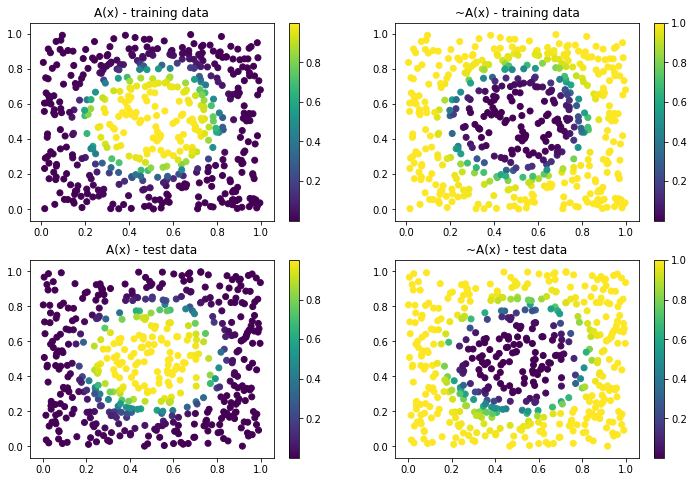

In [11]:
plt.figure(figsize=(12,8))
result=ltnw.ask("A(?data)")
plt.subplot(2,2,1)
plt.scatter(data[:,0],data[:,1],c=result.squeeze())
plt.colorbar()
plt.title("A(x) - training data")

result=ltnw.ask("~A(?data)")
plt.subplot(2,2,2)
plt.scatter(data[:,0],data[:,1],c=result.squeeze())
plt.colorbar()
plt.title("~A(x) - training data")

data_test=np.random.uniform([0,0],[1.,1.],(500,2)).astype(np.float32)
ltnw.variable("?data_test",data_test)
result=ltnw.ask("A(?data_test)")
plt.subplot(2,2,3)
plt.title("A(x) - test")
plt.scatter(data_test[:,0],data_test[:,1],c=result.squeeze());
plt.colorbar();
plt.title("A(x) - test data");

result=ltnw.ask("~A(?data_test)");
plt.subplot(2,2,4);
plt.scatter(data_test[:,0],data_test[:,1],c=result.squeeze());
plt.colorbar();
plt.title("~A(x) - test data");
plt.show();